# Teraquop fit plots

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict
from typing import Optional, List
import math
import sinter
import matplotlib
import rsmf
from main.codes.tic_tac_toe.gauge.GaugeFloquetColourCode import GaugeFloquetColourCode
from main.codes.tic_tac_toe.gauge.GaugeHoneycombCode import GaugeHoneycombCode
formatter : plt.Figure = rsmf.setup(r"\documentclass[a4paper,11pt,noarxiv]{quantumarticle}")
%matplotlib inline


In [2]:
def filter_stats(stats, metadeta_entries: dict() = None, decoder = None):
    for metadeta_key, metadeta_value in metadeta_entries.items():
        stats = [stat for stat in stats if stat.json_metadata[metadeta_key] == metadeta_value]
    if decoder:
        stats = [stat for stat in stats if stat.decoder == decoder]
    return stats

def distance_to_hight(distance_fit: sinter.Fit, code_string: str, letter):
    if code_string[0] == "GaugeFloquetColourCode":
        code = GaugeFloquetColourCode(4, [code_string[1], code_string[2]])
    elif code_string[0] == "GaugeHoneycombCode":
        code = GaugeHoneycombCode(4, [code_string[1], code_string[2], code_string[3]])
    hight_low = code.get_graphlike_timelike_distance(math.ceil(distance_fit.low), letter, 'phenomenological_noise')
    hight_best = code.get_graphlike_timelike_distance(math.ceil(distance_fit.best), letter, 'phenomenological_noise')
    hight_high = code.get_graphlike_timelike_distance(math.ceil(distance_fit.high), letter, 'phenomenological_noise')
    return(sinter.Fit(hight_low, hight_best, hight_high))


In [3]:
def get_sinter_fit(log_ps, sqrt_qs, target_x, stat):
    if len(log_ps) < 2:
        print('error, less than 2 points')
        return None
    
    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.best >= 0:
        return None
    
    if slope_fit.high >= 0:
        # Slope is going the wrong way! Definitely over threshold.
        print('error, slope is going the wrong way')
        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=target_x,
        max_extra_squared_error=1,  
    )
    return (fit)



In [4]:
def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        target_p: float,
) -> Optional[sinter.Fit]:
    """Taken from Craig Gidney's code.
    
    Args:
        group: A list of TaskStats objects.
        target_p: The target probability of failure, for teraquop use 1e-12.

    Returns:
        A Fit object representing the footprint that would achieve the target
        probability of failure, or None if the data was insufficient.
    """
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:

                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata['distance']**2)) # huh why am is squaring and then taking the square root?
                log_ps.append(math.log(p_unit))
            



    return get_sinter_fit(log_ps, sqrt_qs, math.log(target_p), stat)

In [5]:
stats_memory : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/data/memory_0.001.csv')
stats_stability : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/data/stability_0.001.csv')
print(stats_memory[0])
stats_memory_x_pymatching = filter_stats(stats_memory, metadeta_entries = {'per': 0.001, 'logical_observable': 'memory_x', 'gf_0': 1, 'gf_1': 1, 'pm': 1.0, 'px': 1.0, 'pz': 1.0, 'py': 1.0})
stats_memory_z_pymatching = filter_stats(stats_memory, metadeta_entries = {'per': 0.001, 'logical_observable': 'memory_z', 'gf_0': 1, 'gf_1': 1, 'pm': 1.0, 'px': 1.0, 'pz': 1.0, 'py': 1.0})
stats_stability_x_pymatching = filter_stats(stats_stability, metadeta_entries = {'per': 0.001, 'logical_observable': 'stability_x', 'gf_0': 1, 'gf_1': 1, 'pm': 1.0, 'px': 1.0, 'pz': 1.0, 'py': 1.0})
stats_stability_z_pymatching = filter_stats(stats_stability, metadeta_entries= {'per': 0.001, 'logical_observable': 'stability_z', 'gf_0': 1, 'gf_1': 1, 'pm': 1.0, 'px': 1.0, 'pz': 1.0, 'py': 1.0})

   1000000,        42,         0,    36.4,pymatching,4578c0e10d08958bf4a5f90394a6b5c5f307f3bd1302130970b05b78bc67ed8b,"{""code_name"":""GaugeFloquetColourCode"",""distance"":12,""gf_0"":1,""gf_1"":1,""gf_2"":0,""logical_observable"":""memory_x"",""per"":0.001,""pm"":1.0,""px"":1.0,""py"":1.0,""pz"":1.0}",


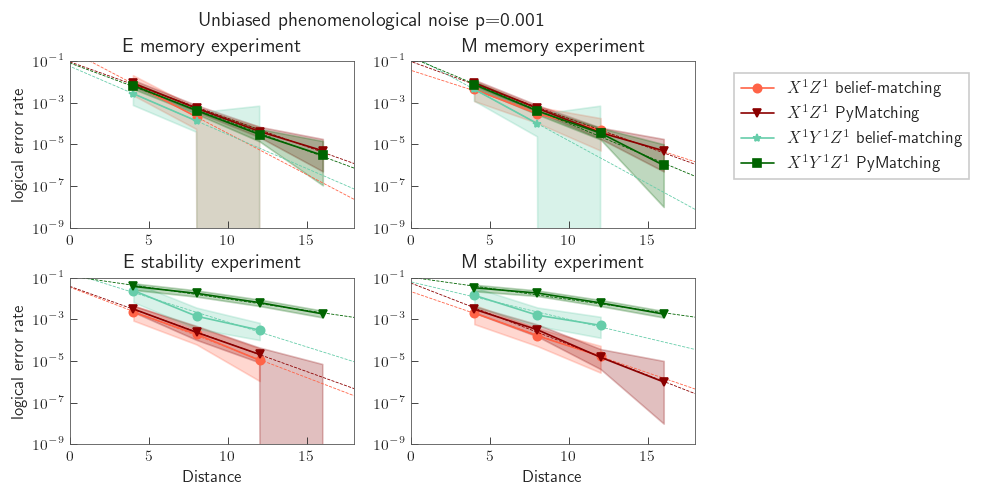

In [30]:
fig = formatter.figure(wide=True)

axes = fig.subplots(2,2)

def distance_to_rounds_XZ(rounds, pauli_letter):
    return(GaugeFloquetColourCode(4, [1,1]).get_number_of_rounds_for_single_timelike_distance(rounds, pauli_letter, True, 'phenomenological_noise'))

def distance_to_rounds_XYZ(rounds, pauli_letter):
    return(GaugeHoneycombCode(4,[1,1,1]).get_number_of_rounds_for_single_timelike_distance(rounds, pauli_letter, True, 'phenomenological_noise'))

curve_id_to_color = {(0,'pymatching'): 'darkred', (0,'beliefmatching'): 'tomato', (1,'pymatching'): 'darkgreen', (1,'beliefmatching'): 'mediumaquamarine'}



plot_args_func=lambda index, curve_id: {'color': curve_id_to_color[curve_id], 'linewidth': 1, 'markersize': 5}
f_func = lambda stat: stat.json_metadata['gf_2'] < 2
g_func = lambda stat: (stat.json_metadata['gf_2'],stat.decoder)
x_axis_func = lambda stat: stat.json_metadata['distance']


sinter.plot_error_rate(ax=axes[0][0], 
                       stats=stats_memory_x_pymatching,
                        x_func= x_axis_func,
                        group_func= g_func,
                        filter_func= f_func,
                        plot_args_func=plot_args_func,
                        line_fits=('linear', 'log')

    )

sinter.plot_error_rate(ax=axes[0][1], stats=stats_memory_z_pymatching,
                        x_func= x_axis_func,
                        group_func= g_func,
                        filter_func= f_func,
                        plot_args_func=plot_args_func,
                        line_fits=('linear', 'log')
    )

sinter.plot_error_rate(ax=axes[1][0], stats=stats_stability_x_pymatching,
                        x_func=  lambda stat: stat.json_metadata['distance'],
                        group_func= g_func,
                        filter_func= lambda stat: stat.json_metadata['gf_2'] == 0, 
                        plot_args_func=plot_args_func,
                        line_fits=('linear', 'log')


    )

sinter.plot_error_rate(ax=axes[1][0], stats=stats_stability_x_pymatching,
                        x_func= lambda stat: stat.json_metadata['distance'],
                        group_func= g_func,
                        filter_func= lambda stat: stat.json_metadata['gf_2'] == 1, 
                        plot_args_func=plot_args_func,
                        line_fits=('linear', 'log')

    )


sinter.plot_error_rate(ax=axes[1][1], stats=stats_stability_z_pymatching,
                        x_func=  lambda stat: stat.json_metadata['distance'],
                        group_func= g_func,
                        filter_func= lambda stat: stat.json_metadata['gf_2'] == 0, 
                        plot_args_func=plot_args_func,
                        line_fits=('linear', 'log')

    )

sinter.plot_error_rate(ax=axes[1][1], stats=stats_stability_z_pymatching,
                        x_func= lambda stat: stat.json_metadata['distance'],
                        group_func= g_func,
                        filter_func= lambda stat: stat.json_metadata['gf_2'] == 1, 
                        plot_args_func=plot_args_func,
                        line_fits=('linear', 'log')

    )

for ax in axes.flatten():
    ax.set_yscale('log')
    ax.set_xlim(0,18)
    ax.set_ylim(1e-9, 1e-1)
#    ax.set_markersize(10)
fig.suptitle('Unbiased phenomenological noise p=0.001')
#axes.title('linefit plots unbiased phenomenological noise p=0.0001')

axes[1][0].set_xlabel('Distance')
axes[1][1].set_xlabel('Distance')
axes[0][0].set_ylabel('logical error rate')
axes[1][0].set_ylabel('logical error rate')

axes[0][0].set_title('E memory experiment')
axes[0][1].set_title('M memory experiment')
axes[1][0].set_title('E stability experiment')
axes[1][1].set_title('M stability experiment')

handles, labels = axes[0][0].get_legend_handles_labels()
labels = ['$X^1Z^1$ belief-matching', '$X^1Z^1$ PyMatching', '$X^1Y^1Z^1$ belief-matching', '$X^1Y^1Z^1$ PyMatching']
fig.legend(handles, labels, bbox_to_anchor=(1.25, 0.75), loc='center right')

plt.subplots_adjust(hspace=0.3)
plt.savefig(f"plots/X1Y1Z1_X1Z1_teraquop_linefits.pdf", bbox_inches='tight')

plt.show()
